https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv

order_products__*.csv
- These files specify which products were purchased in each order. order_products__prior.csv contains previous order contents for all customers. 'reordered' indicates that the customer has a previous order that contains the product. Note that some orders will have no reordered items. You may predict an explicit 'None' value for orders with no reordered items. See the evaluation page for full details.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import random
import seaborn as sns
sns.set()
color = sns.color_palette()
import gc

In [26]:
%%time
os.chdir("C:/Users/anuka/OneDrive/Desktop/Anu/Interview Prep/Springboard/Curriculum/Capstone project 2/Instacart Market Basket Analysis/instacart-market-basket-analysis")

aisles = pd.read_csv("aisles/aisles.csv",parse_dates=True, skiprows=0, na_values = ['NaN'], encoding='utf-8',
                    dtype={'aisle_id': np.uint16, 'aisle': 'category'})

departments = pd.read_csv("departments/departments.csv",parse_dates=True, skiprows=0, na_values = ['NaN'],
                         dtype={'department_id': np.uint16, 'department': 'category'})

order_products_prior = pd.read_csv("order_products__prior/order_products__prior.csv",parse_dates=True, skiprows=0, na_values = ['NaN'],
                    dtype={'order_id': np.int32,'product_id': np.uint16,'add_to_cart_order': np.int16,'reordered': np.int8})

order_products_train = pd.read_csv("order_products__train/order_products__train.csv",parse_dates=True, skiprows=0, na_values = ['NaN'],
                   dtype={'order_id': np.int32, 'product_id': np.uint16, 'add_to_cart_order': np.int16,'reordered': np.int8})

orders = pd.read_csv("orders/orders.csv",parse_dates=True, skiprows=0, na_values = ['NaN'],
                    dtype={'order_id': np.int32,'user_id': np.int32,'eval_set': 'category','order_number': np.int16,
                           'order_dow': np.int8,'order_hour_of_day': np.int8,'days_since_prior_order': np.float32})

products = pd.read_csv("products/products.csv",parse_dates=True, skiprows=0, na_values = ['NaN'], 
                       dtype={'product_id': np.uint16, 'order_id': np.int32, 'aisle_id': np.uint8,'department_id': np.uint8},
                       usecols=['product_id', 'product_name', 'aisle_id', 'department_id'])

sample_submission = pd.read_csv("sample_submission/sample_submission.csv",parse_dates=True, skiprows=0, na_values = ['NaN'])

Wall time: 12 s


In [15]:
# order_products_prior.info(memory_usage=True)
# order_products_prior.memory_usage(deep=True)* 1e-6
print(order_products_prior.memory_usage(deep=True).sum())
order_products_prior.memory_usage(deep=True)

291910529


Index                      128
order_id             129737956
product_id            64868978
add_to_cart_order     64868978
reordered             32434489
dtype: int64

In [18]:
print("The size of aisles is: ",aisles.shape)
print("The size of departments is: ",departments.shape)
print("The size of order_products_prior is: ",order_products_prior.shape)
print("The size of order_products_train is: ",order_products_train.shape)
print("The size of orders is: ",orders.shape) # Unique at order level
print("The size of products is: ",products.shape)
# print("The size of sample_submission is: ",sample_submission.shape)

The size of aisles is:  (134, 2)
The size of departments is:  (21, 2)
The size of order_products_prior is:  (32434489, 4)
The size of order_products_train is:  (1384617, 4)
The size of orders is:  (3421083, 7)
The size of products is:  (49688, 3)


In [24]:
products_detailed_1.head()

,product_id,aisle_id,department_id,aisle,department
0,1,61,19,cookies cakes,snacks
1,2,104,13,spices seasonings,pantry
2,3,94,7,tea,beverages
3,4,38,1,frozen meals,frozen
4,5,5,13,marinades meat preparation,pantry


In [25]:
products.head()

,product_id,aisle_id,department_id
0,1,61,19
1,2,104,13
2,3,94,7
3,4,38,1
4,5,5,13


In [27]:
products_detailed = products.merge(aisles, how = 'left', left_on='aisle_id',right_on='aisle_id')
products_detailed_1 = products_detailed.merge(departments, how = 'left', left_on='department_id',right_on='department_id')
products_detailed_1.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


In [5]:
# orders.head()
# So there are 206,209 customers in total. Out of which, the last purchase of 131,209 customers are given as 
# train set and we need to predict for the rest 75,000 customers.
print(orders.groupby('eval_set').agg({'order_id': 'nunique', 'user_id':'nunique'}))
print("The unique count of orders in order_products_prior is: ",order_products_prior.order_id.nunique())
print("The unique count of orders in order_products_train is: ",order_products_train.order_id.nunique())
print("The unique count of orders in sample_submission is: ",sample_submission.order_id.nunique())
print("\n")
print("The unique count of orders in order_products_prior, order_products_train and sample_submission is: ",
      order_products_prior.order_id.nunique()+order_products_train.order_id.nunique()+sample_submission.order_id.nunique())

print("\n")
print("The unique count of orders in orders is: ",orders.order_id.nunique()) # orders data is unique at order level

          order_id  user_id
eval_set                   
prior      3214874   206209
test         75000    75000
train       131209   131209
The unique count of orders in order_products_prior is:  3214874
The unique count of orders in order_products_train is:  131209
The unique count of orders in sample_submission is:  75000


The unique count of orders in order_products_prior, order_products_train and sample_submission is:  3421083


The unique count of orders in orders is:  3421083


In [6]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [7]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [29]:
priors_1 = order_products_prior.merge(orders, how = 'left', left_on='order_id',right_on='order_id' )
# Merge with orders data to get order details
priors_2 = priors_1.merge(products_detailed_1, how = 'left', left_on='product_id',right_on='product_id')
priors_1.shape

(32434489, 10)

In [21]:
gc.collect()

64

In [11]:
# order_products_2.to_csv("C:/Users/anuka/OneDrive/Desktop/Anu/Interview Prep/Springboard/Curriculum/Capstone project 2/Instacart Market Basket Analysis/instacart-market-basket-analysis/order_products_2.csv")

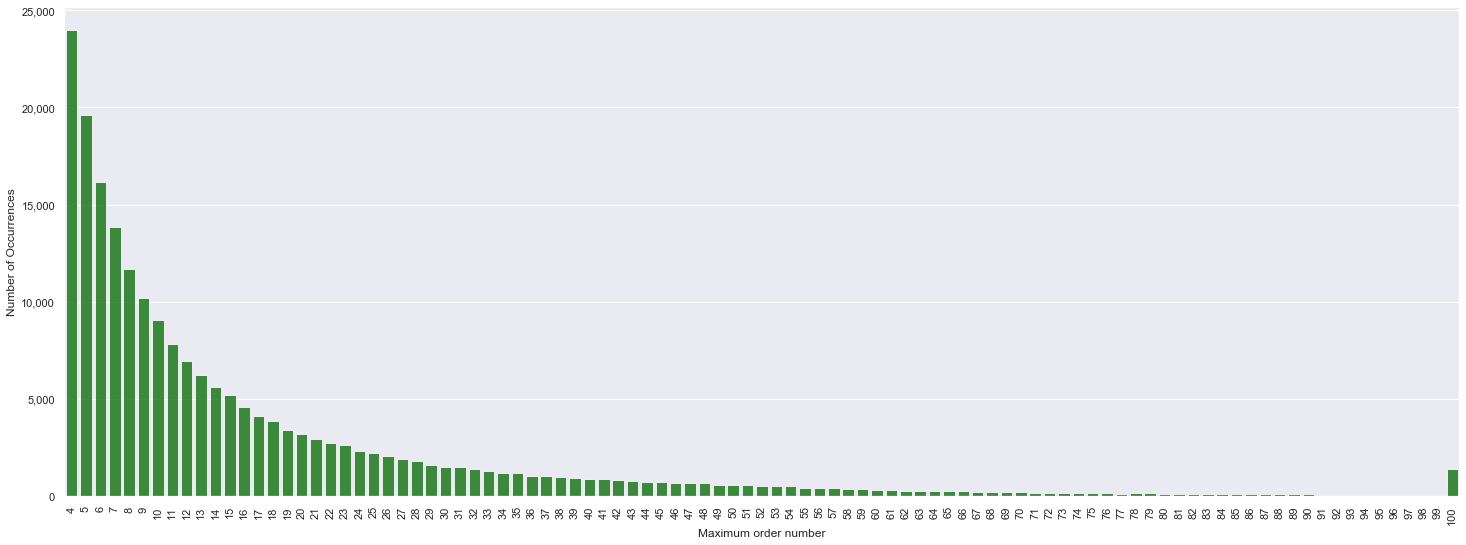

In [21]:
# There are no users with less than 4 and more 100 orders
import matplotlib
cnt_srs = orders.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()
plt.figure(figsize=(25,9))
ax = sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

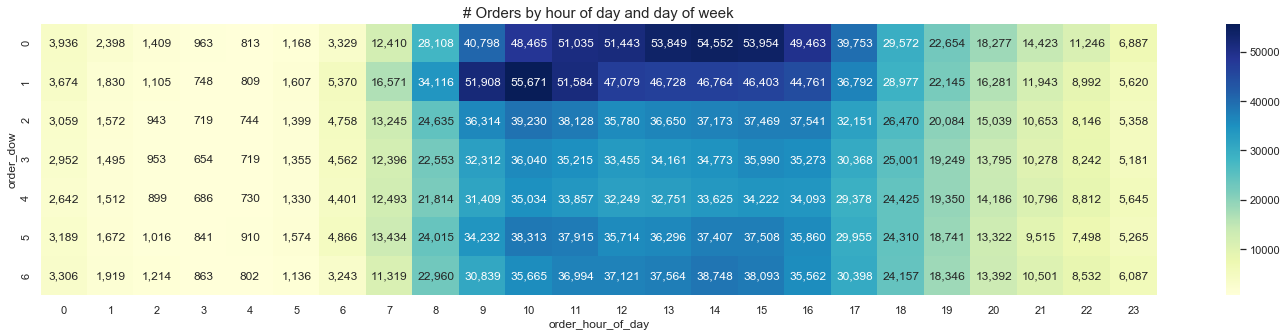

In [24]:
# Saturday afternoon and Sunday mornings/afternoons have high order frequencies
pivot_1 = orders.pivot_table('order_id', index=['order_dow'], columns=['order_hour_of_day'],aggfunc='count').fillna(0).astype(int)
fig, ax = plt.subplots(figsize=(25,5))
ax = sns.heatmap(pivot_1,annot=True, fmt="d", cmap="YlGnBu")
ax.set_title("# Orders by hour of day and day of week", fontsize=15)
for t in ax.texts:
    t.set_text('{:,d}'.format(int(t.get_text())))
plt.show()

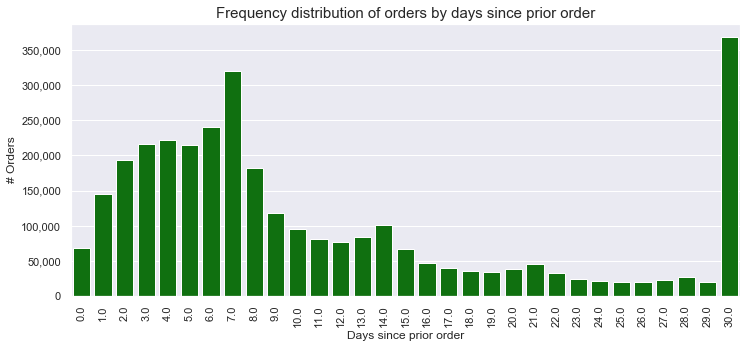

In [23]:
# Looks like customers order once in every week (check the peak at 7 days) or once in a month (peak at 30 days). 
# We could also see smaller peaks at 14, 21 and 28 days (weekly intervals).
plt.figure(figsize=(12,5))
ax = sns.countplot(x="days_since_prior_order", data=orders, color="green")
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.ylabel('# Orders', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution of orders by days since prior order", fontsize=15)
plt.show()

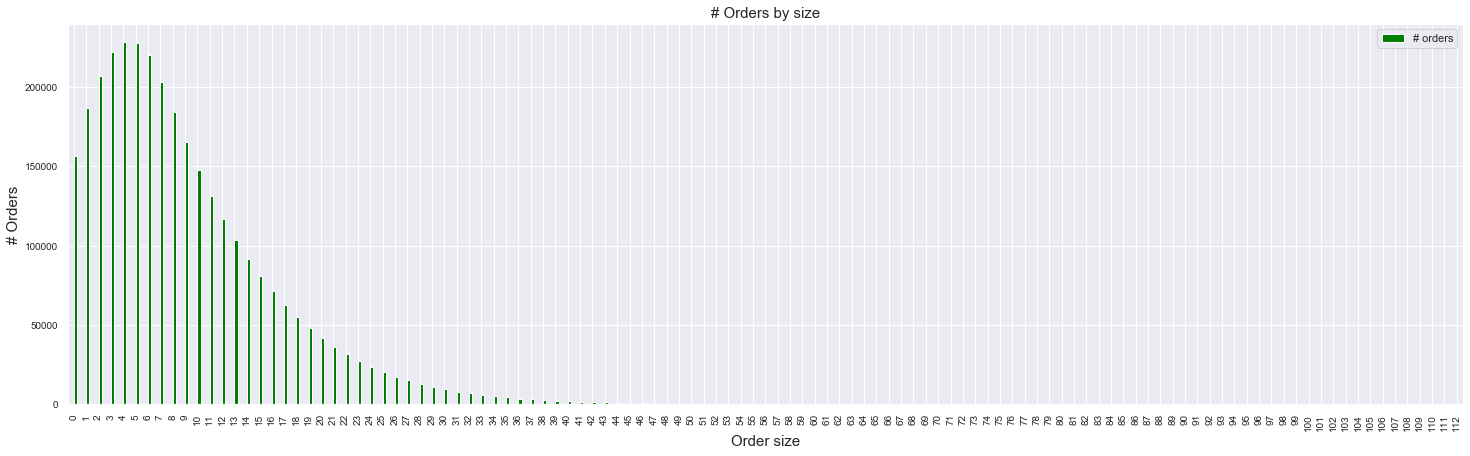

In [22]:
# A right tailed distribution with maximum value at 5
# Maximum order size is 5, with most orders with 3-7 products
df_order_size = priors_1.groupby(['order_id']).agg({'add_to_cart_order':'max'})
df_order_size.reset_index(inplace=True)
df_order_size_1 = df_order_size.groupby(['add_to_cart_order']).agg({'order_id': 'count'})
df_order_size_1.reset_index(inplace=True)
ax = df_order_size_1.plot(kind='bar', figsize=(25,7), color="green", fontsize=10);
ax.set_alpha(0.8)
ax.set_title("# Orders by size", fontsize=15)
ax.set_ylabel("# Orders", fontsize=15)
ax.set_xlabel("Order size", fontsize=15)
ax.legend(["# orders"])
plt.show()
del df_order_size
del df_order_size_1

In [119]:
# On an average, about 59% of the products in an order are re-ordered products.
print(order_products.reordered.sum()/order_products.shape[0])

0.5900617242809434


In [19]:
order_products_1.groupby(['eval_set']).agg({'order_id': 'nunique'})

,order_id
eval_set,
prior,3214874
train,131209


In [31]:
priors_1.order_id.nunique()

3214874

In [30]:
# Determine top 20 products by orders and # times they were ordered and reordered
# Most of the top products are fuits and vegetables
df = priors_1.groupby(['product_id']).agg({'order_id':'nunique','reordered': 'mean'})
df.reset_index(inplace=True)
df['cnt_orders'] = df['order_id']
df['reordered_ratio'] = df['reordered']
df_top20 = df.sort_values(['cnt_orders'], ascending=False).head(20)
df_top20_1 = df_top20.merge(products_detailed_1, how = 'left', left_on='product_id',right_on='product_id')
df_top20_1[['aisle','department','product_name', 'cnt_orders','reordered_ratio']]

,aisle,department,product_name,cnt_orders,reordered_ratio
0,fresh fruits,produce,Banana,472565,0.843501
1,fresh fruits,produce,Bag of Organic Bananas,379450,0.832555
2,fresh fruits,produce,Organic Strawberries,264683,0.777704
3,packaged vegetables fruits,produce,Organic Baby Spinach,241921,0.772500
4,fresh fruits,produce,Organic Hass Avocado,213584,0.796553
5,fresh fruits,produce,Organic Avocado,176815,0.758103
6,fresh fruits,produce,Large Lemon,152657,0.696038
7,fresh fruits,produce,Strawberries,142951,0.698155
8,fresh fruits,produce,Limes,140627,0.681007
9,milk,dairy eggs,Organic Whole Milk,137905,0.830354


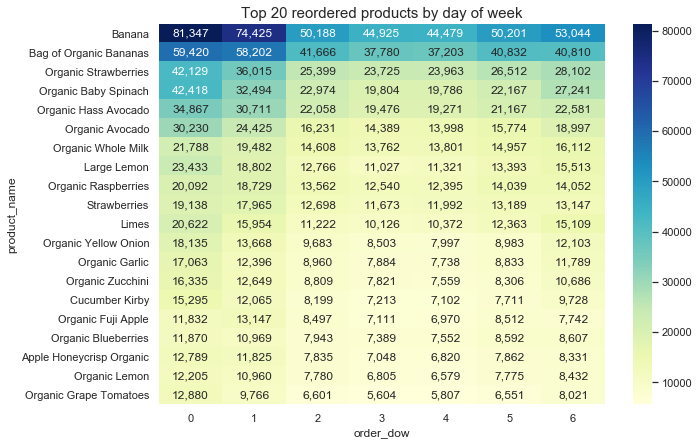

In [39]:
# Reordered products by top 20 products and day of week
# Banana is the most reorderd product and mostly ordered on Saturday and Sunday
df_top20_2 = df_top20_1[['aisle','department','product_name', 'product_id']]
order_products_cols = priors_1[['order_id','product_id','order_dow','order_hour_of_day','reordered']]
df_top20_prod_order = df_top20_2.merge(order_products_cols, how = 'left', left_on='product_id',right_on='product_id')
pivot_prod_dow = df_top20_prod_order.pivot_table('reordered', index=['product_name'], columns=['order_dow'],aggfunc='sum').fillna(0).astype(int)
columns = list(range(7))
pivot_prod_dow['Total'] = pivot_prod_dow.loc[:,0:7].sum(axis=1)
pivot_prod_dow = pivot_prod_dow.sort_values('Total', ascending=False)
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.heatmap(pivot_prod_dow[columns],annot=True, fmt="d", cmap="YlGnBu")
ax.set_title("Top 20 reordered products by day of week", fontsize=15)
for t in ax.texts:
    t.set_text('{:,d}'.format(int(t.get_text())))
plt.show()

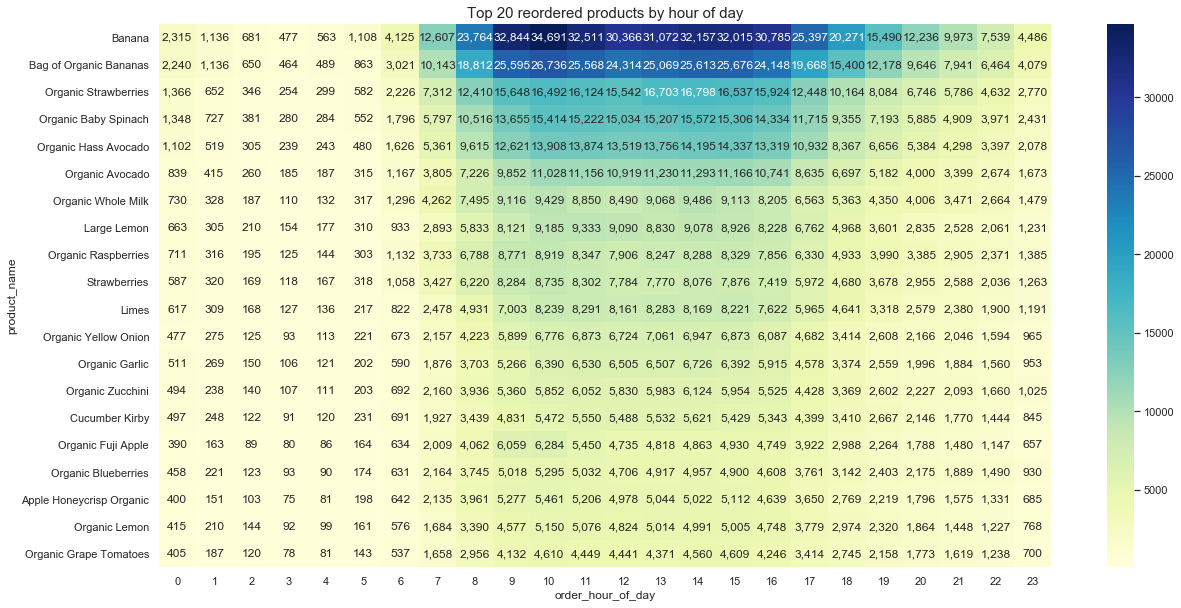

In [41]:
# Reordered top 20 products by hour of day
# Banana is the most ordered and reorderd product and mostly in the afternoon hours
pivot_prod_hod = df_top20_prod_order.pivot_table('reordered', index=['product_name'], columns=['order_hour_of_day'],aggfunc='sum').fillna(0).astype(int)
columns = list(range(24))
pivot_prod_hod['Total'] = pivot_prod_hod.loc[:,0:24].sum(axis=1)
pivot_prod_hod = pivot_prod_hod.sort_values('Total', ascending=False)
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(pivot_prod_hod[columns],annot=True, fmt="d", cmap="YlGnBu")
ax.set_title("Top 20 reordered products by hour of day", fontsize=15)
for t in ax.texts:
    t.set_text('{:,d}'.format(int(t.get_text())))
plt.show()

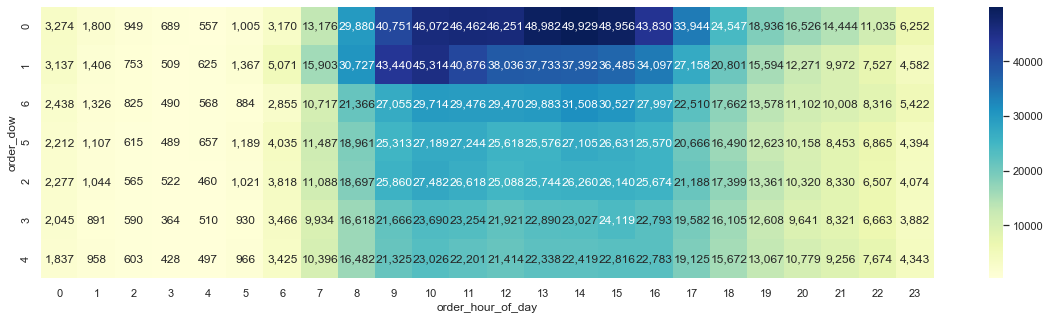

In [173]:
# Reordered products by day of week and hour of day
# Top 20 products orders are mostly ordered on Saturday and Sunday, during afternoon hours
pivot_time = df_top20_prod_order.pivot_table('reordered', index=['order_dow'], columns=['order_hour_of_day'],aggfunc='sum').fillna(0).astype(int)
columns = list(range(24))
pivot_time['Total'] = pivot_time.loc[:,0:24].sum(axis=1)
pivot_time = pivot_time.sort_values('Total', ascending=False)
fig, ax = plt.subplots(figsize=(20,5))
ax = sns.heatmap(pivot_time[columns],annot=True, fmt="d", cmap="YlGnBu")
for t in ax.texts:
    t.set_text('{:,d}'.format(int(t.get_text())))
plt.show()

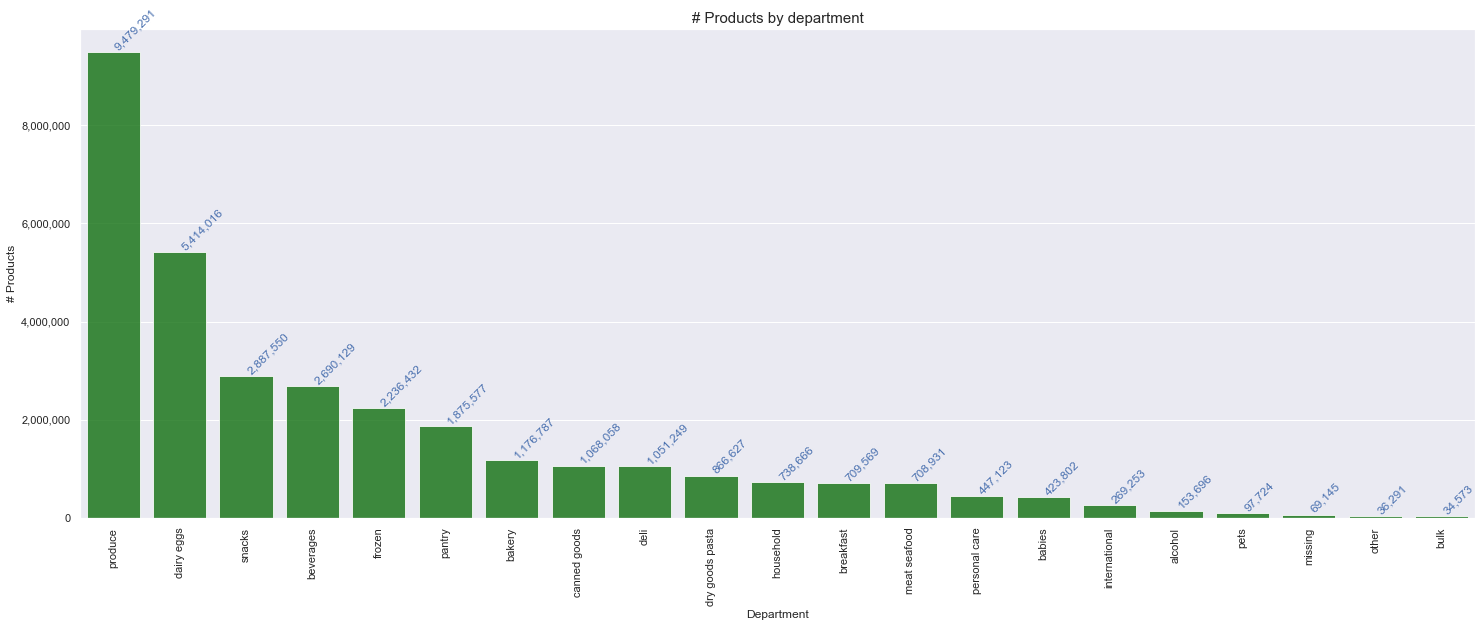

In [68]:
import matplotlib
cnt_dept = priors_2.groupby('department').agg({'product_id':'count'}).reset_index()
cnt_dept.sort_values('product_id', ascending=False, inplace=True)
# cnt_dept.set_index('product_id', inplace=True)
cnt_dept
plt.figure(figsize=(25,9))
ax = sns.barplot(cnt_dept.department, cnt_dept.product_id, alpha=0.8, color='green',
                order = ['produce','dairy eggs','snacks','beverages','frozen','pantry','bakery','canned goods',
                         'deli','dry goods pasta','household','breakfast','meat seafood','personal care','babies',
                         'international','alcohol','pets','missing','other','bulk'])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.ylabel('# Products', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("# Products by department", fontsize=15)
plt.xticks(rotation='vertical')
for i, v in enumerate(cnt_dept["product_id"].iteritems()):        
    ax.text(i ,v[1], "{:,}".format(v[1]), color='b', va ='bottom', rotation=45)
plt.show()

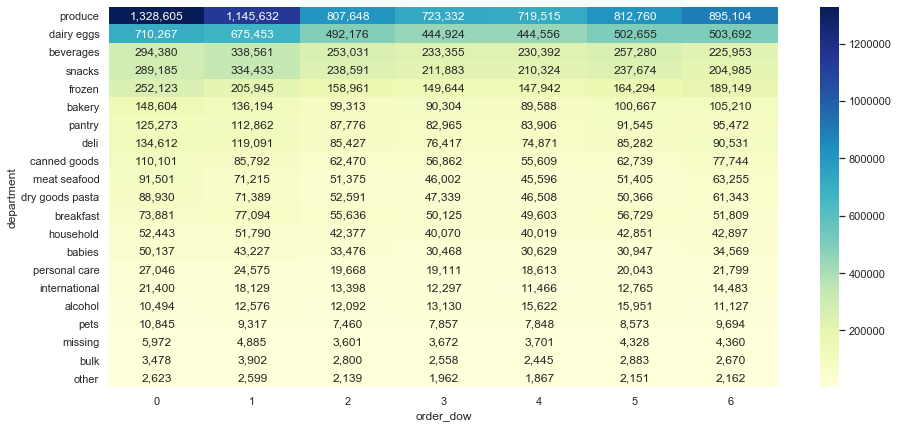

In [124]:
# Reorderd products by department and day of week
df_dow = priors_1.groupby(['product_id', 'order_dow']).agg({'order_id':'nunique','reordered': 'sum'})
df_dow.reset_index(inplace=True)
df_dow_1 = df_dow.merge(products_detailed_1, how = 'left', left_on='product_id',right_on='product_id')
pivot_dow = df_dow_1.pivot_table('reordered', index=['department'], columns=['order_dow'],aggfunc='sum').fillna(0).astype(int)
columns = list(range(7))
pivot_dow['Total'] = pivot_dow.loc[:,0:7].sum(axis=1)
pivot_dow = pivot_dow.sort_values('Total', ascending=False)
fig, ax = plt.subplots(figsize=(15,7))
ax = sns.heatmap(pivot_dow[columns],annot=True, fmt="d",cmap="YlGnBu")
for t in ax.texts:
    t.set_text('{:,d}'.format(int(t.get_text())))
plt.show()

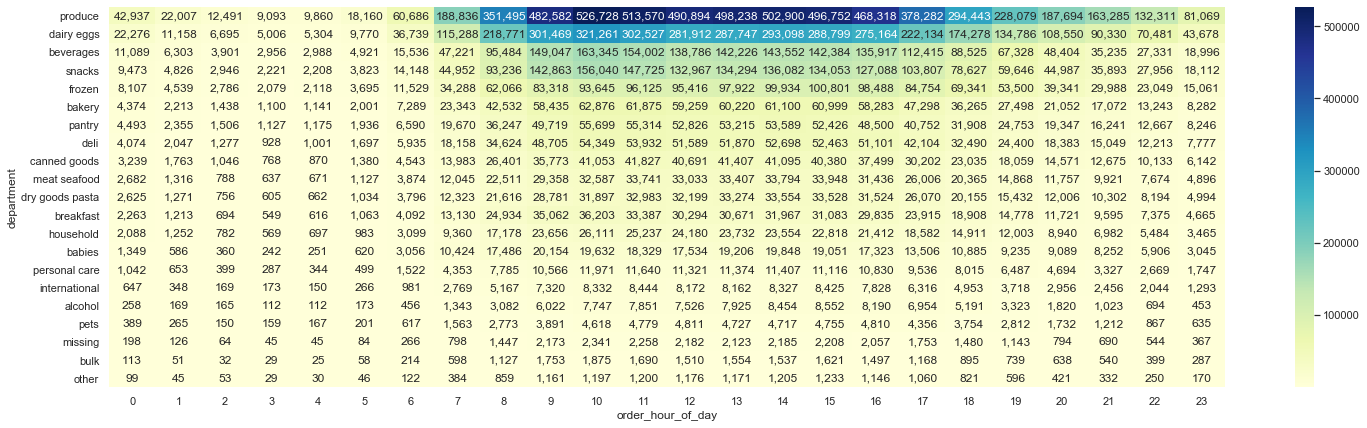

In [38]:
# Reorderd products by hour of day and department
df_hod = priors_1.groupby(['product_id', 'order_hour_of_day']).agg({'order_id':'nunique','reordered': 'sum'})
df_hod.reset_index(inplace=True)
df_hod_1 = df_hod.merge(products_detailed_1, how = 'left', left_on='product_id',right_on='product_id')
pivot_hod = df_hod_1.pivot_table('reordered', index=['department'], columns=['order_hour_of_day'],aggfunc='sum').fillna(0).astype(int)
pivot_hod['Total'] = pivot_hod.loc[:,0:24].sum(axis=1)
pivot_hod = pivot_hod.sort_values('Total', ascending=False)
columns = list(range(24))
fig, ax = plt.subplots(figsize=(25,7))
ax =sns.heatmap(pivot_hod[columns],annot=True, fmt="d",cmap="YlGnBu")
for t in ax.texts:
    t.set_text('{:,d}'.format(int(t.get_text())))
plt.show()

In [69]:
# Number of orders by Aisle
# Fresh fruits and vegetables are most ordered product aisles
# cnt_ais = priors_2['aisle'].value_counts().head(20)
# plt.figure(figsize=(12,5))
# sns.barplot(cnt_ais.index, cnt_ais.values, alpha=0.8, color="green")
# plt.ylabel('Number of times a product is ordered', fontsize=12)
# plt.xlabel('Aisle', fontsize=12)
# plt.xticks(rotation='vertical')
# plt.show()

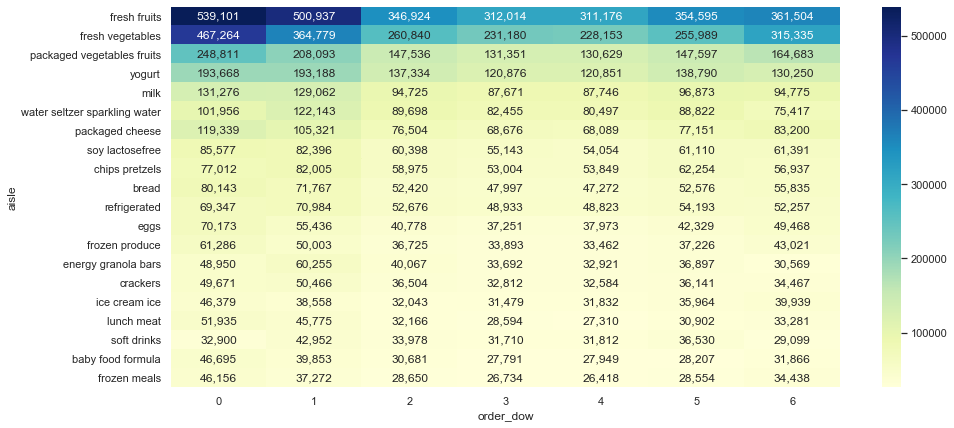

In [131]:
# Reorderd products by day of week and top 20 aisle
# Fresh fruits and vegetables are most ordered and reordered product aisles
pivot_dow_aisle = df_dow_1.pivot_table('reordered', index=['aisle'], columns=['order_dow'],aggfunc='sum').fillna(0).astype(int)
pivot_dow_aisle['Total'] = pivot_dow_aisle.loc[:,0:24].sum(axis=1)
pivot_dow_aisle = pivot_dow_aisle.sort_values('Total', ascending=False)
fig, ax = plt.subplots(figsize=(15,7))
columns = list(range(7))
ax = sns.heatmap(pivot_dow_aisle[columns].head(20), annot=True, fmt="d", cmap="YlGnBu")
for t in ax.texts:
    t.set_text('{:,d}'.format(int(t.get_text())))
plt.show()

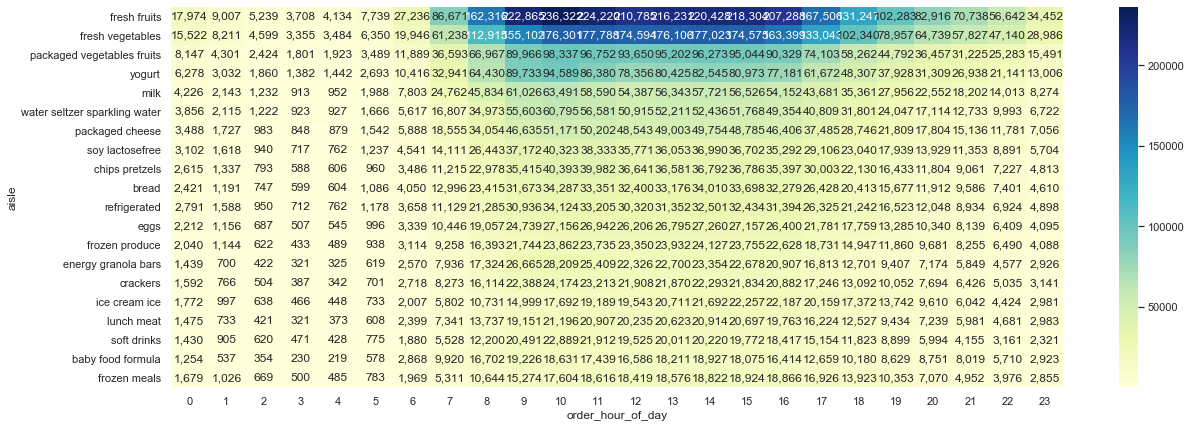

In [134]:
# Reorderd products by Hour of Day and Aisle
pivot_hod_aisle = df_hod_1.pivot_table('reordered', index=['aisle'], columns=['order_hour_of_day'],aggfunc='sum').fillna(0).astype(int)
pivot_hod_aisle['Total'] = pivot_hod_aisle.loc[:,0:24].sum(axis=1)
pivot_hod_aisle = pivot_hod_aisle.sort_values('Total', ascending=False)
fig, ax = plt.subplots(figsize=(20,7))
columns = list(range(24))
ax = sns.heatmap(pivot_hod_aisle[columns].head(20), annot=True, fmt="d", cmap="YlGnBu")
for t in ax.texts:
    t.set_text('{:,d}'.format(int(t.get_text())))
plt.show()

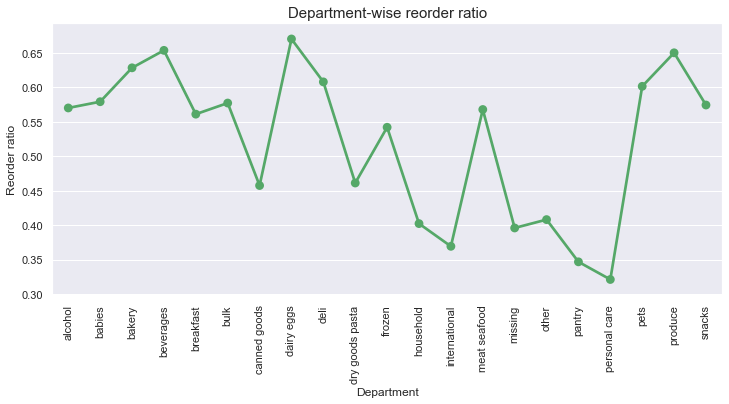

In [32]:
# Reordered ratio by department
# Personal care has lowest reorder ratio and dairy eggs have highest reorder ratio.
grouped_df = priors_2.groupby(["department"]).agg({"reordered": "mean"}).reset_index()
plt.figure(figsize=(12,5))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department-wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

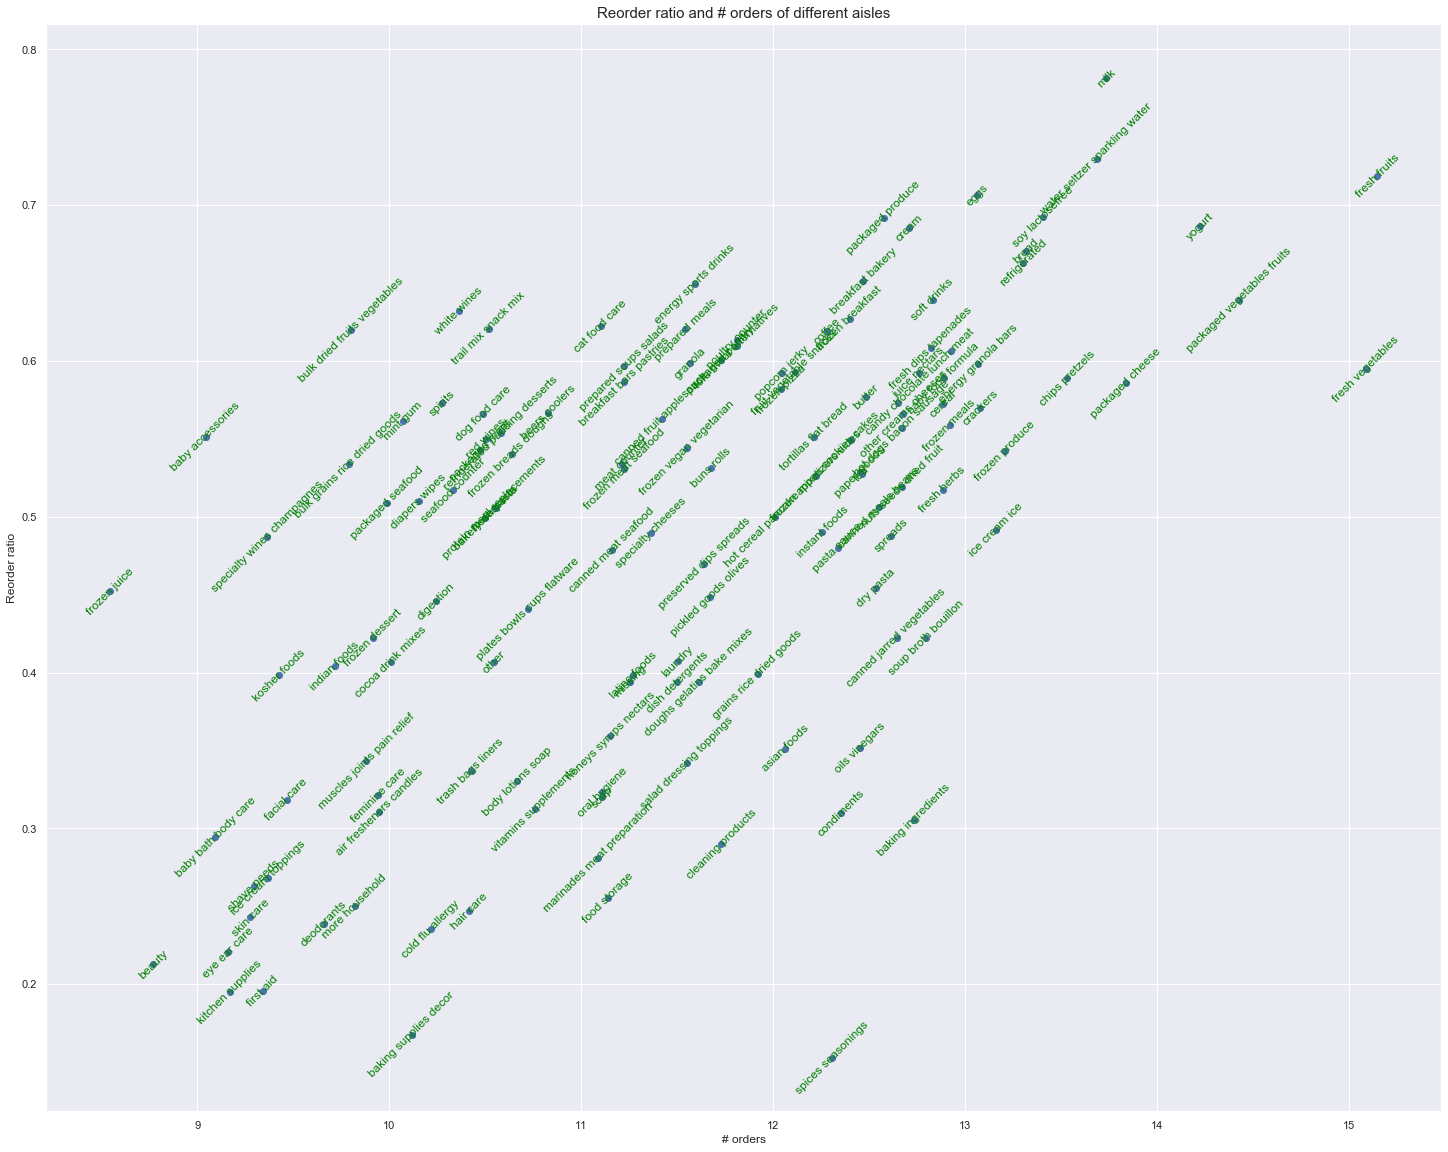

In [19]:
# fresh fruit and fresh vegetables aisles have the highest orders and reordered ratio
grouped_df = order_products_2.groupby(["aisle"]).agg({"order_id": "count","reordered":"mean"}).reset_index()
fig, ax = plt.subplots(figsize=(25,20))
ax.scatter(np.log(grouped_df.order_id), grouped_df.reordered.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (np.log(grouped_df.order_id.values[i]), grouped_df.reordered.values[i]), rotation=45, ha='center', va='center', color='green')
plt.xlabel('log of # orders')
plt.ylabel('Reorder ratio')
plt.title("Reorder ratio and # orders of different aisles", fontsize=15)
plt.show()

In [21]:
# Milk aisle seems to be falling into the wrong department of dairy eggs
order_products_2[order_products_2.aisle=="milk"].head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
34,5,23909,5,1,156122,prior,42,6,16,9.0,2% Reduced Fat Milk,84,16,milk,dairy eggs
98,12,15221,2,1,152610,prior,22,6,8,10.0,2% Milk,84,16,milk,dairy eggs
126,14,27845,2,1,18194,prior,49,3,15,3.0,Organic Whole Milk,84,16,milk,dairy eggs
148,18,36011,5,1,118860,prior,3,4,20,6.0,Organic Fat Free Milk,84,16,milk,dairy eggs
188,22,23909,1,1,30822,prior,25,1,8,12.0,2% Reduced Fat Milk,84,16,milk,dairy eggs


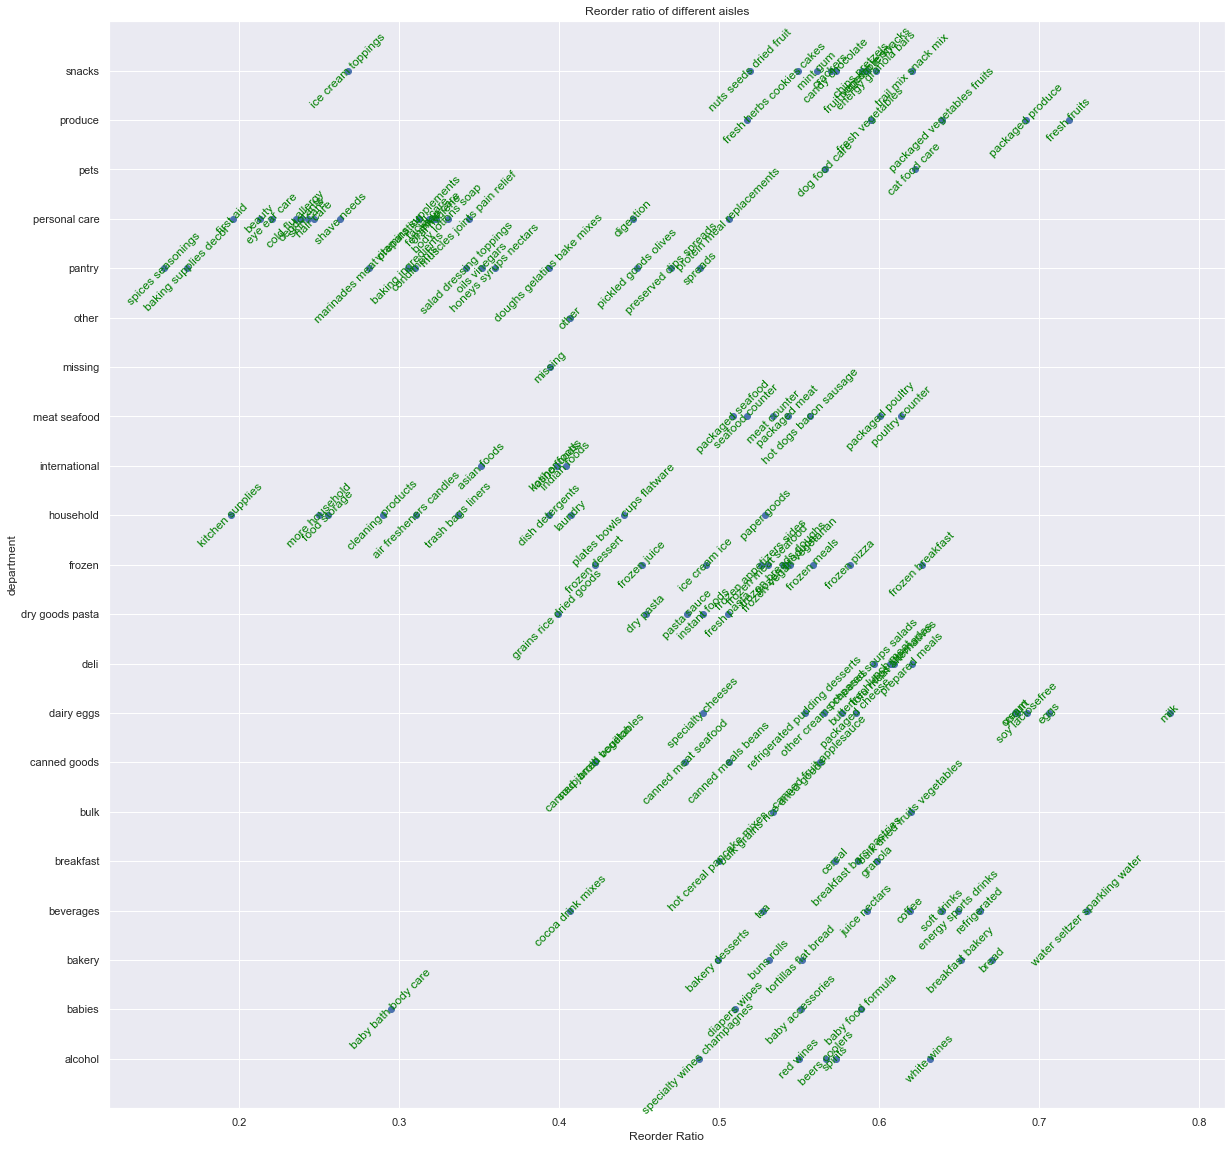

In [20]:
grouped_df = order_products_2.groupby(["department", "aisle"])["reordered"].aggregate("mean").reset_index()
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department.values[i]), rotation=45, ha='center', va='center', color='green')
plt.xlabel('Reorder Ratio')
plt.ylabel('department')
plt.title("Reorder ratio of different aisles", fontsize=12)
plt.show()

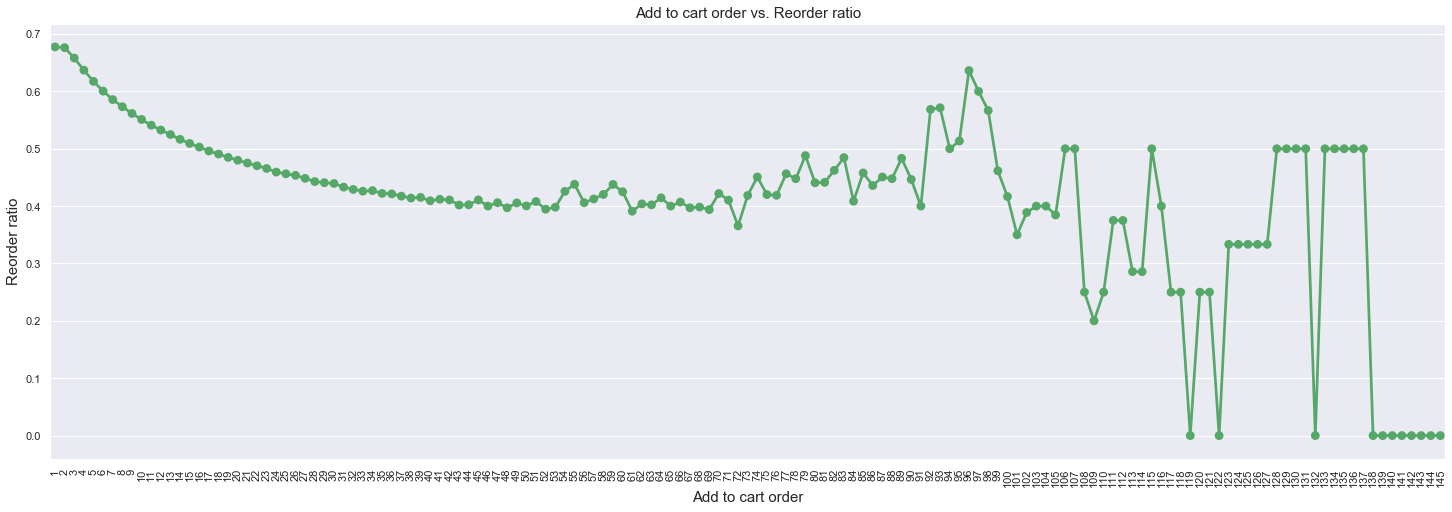

In [33]:
# Looks like the products that are added to the cart initially are more likely to be reordered again compared to the ones 
# added later. This makes sense to me as well since we tend to first order all the products we used to buy frequently and then look out for the new products available.
grouped_df = priors_2.groupby(["add_to_cart_order"])["reordered"].aggregate("mean").reset_index()
plt.figure(figsize=(25,8))
sns.pointplot(grouped_df['add_to_cart_order'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=15)
plt.xlabel('Add to cart order', fontsize=15)
plt.title("Add to cart order vs. Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

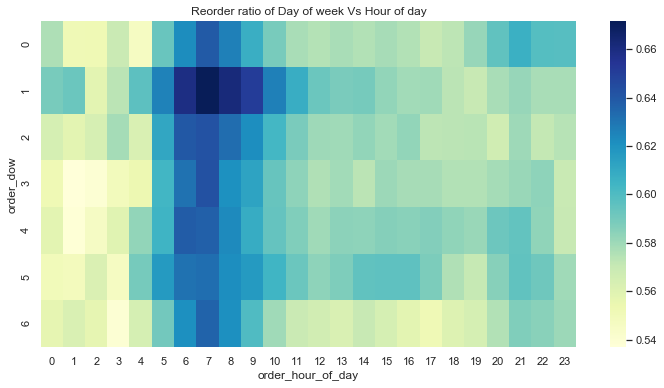

In [35]:
# Looks like most of the reordered or frequently ordered products are ordered in the early morning hours
grouped_df = priors_2.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df, cmap="YlGnBu")
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()